In [ ]:
# !wget https://cdn.discordapp.com/attachments/1102884146684121188/1103262575099125821/pixel_data.zip
# !wget https://cdn.discordapp.com/attachments/1102884146684121188/1103262575501791262/blur_data.zip
# !unzip pixel_data.zip
# !unzip blur_data.zip
!wget https://cdn.discordapp.com/attachments/1102884146684121188/1103316900257218680/all.zip
!unzip all.zip

--2023-05-03 16:26:30--  https://cdn.discordapp.com/attachments/1102884146684121188/1103316900257218680/all.zip
Resolving cdn.discordapp.com (cdn.discordapp.com)... 162.159.134.233, 162.159.129.233, 162.159.135.233, ...
Connecting to cdn.discordapp.com (cdn.discordapp.com)|162.159.134.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14240052 (14M) [application/zip]
Saving to: ‘all.zip’

all.zip             100%[===================>]  13.58M  13.3MB/s    in 1.0s    

2023-05-03 16:26:32 (13.3 MB/s) - ‘all.zip’ saved [14240052/14240052]

Archive:  all.zip
   creating: Blur_25/
   creating: Blur_25/data/
   creating: Blur_25/data/Testing/
   creating: Blur_25/data/Testing/s1/
  inflating: Blur_25/data/Testing/s1/1.jpg  
   creating: Blur_25/data/Testing/s10/
  inflating: Blur_25/data/Testing/s10/10.jpg  
   creating: Blur_25/data/Testing/s11/
  inflating: Blur_25/data/Testing/s11/11.jpg  
   creating: Blur_25/data/Testing/s12/
  inflating: Blur_25/data/Testing

cuda:0
Blur_25 Accuracy of the network on the 1 test images: 30 %
Blur_25 Accuracy of the network on the 2 test images: 30 %
Blur_25 Accuracy of the network on the 3 test images: 67 %
Blur_25 Accuracy of the network on the 4 test images: 62 %
Blur_25 Accuracy of the network on the 5 test images: 67 %
Blur_25 Accuracy of the network on the 6 test images: 82 %
Blur_25 Accuracy of the network on the 7 test images: 75 %
Blur_25 Accuracy of the network on the 8 test images: 85 %
Blur_25 Accuracy of the network on the 9 test images: 77 %
avg 84.66666666666667
Blur_25 Accuracy of the network on the 10 test images: 92 %
avg 86.33333333333333
Blur_25 Accuracy of the network on the 11 test images: 90 %
avg 91.33333333333333
Blur_25 Accuracy of the network on the 12 test images: 92 %
avg 91.33333333333333
Blur_25 Accuracy of the network on the 13 test images: 92 %
avg 92.0
bouto overfitting [92, 92, 92]
Finished Training
Blur_25 Accuracy of the network on the 13 test images: 92 %
Blur_45 Accuracy

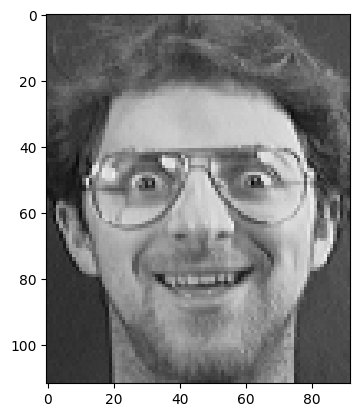

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
# functions to show an image

def imshow(img):
    
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


transform = transforms.Compose(
    [
    #  transforms.Resize((32, 32)),#resize the image to 32*32，有副作用會導致圖片模糊
         # netural network 的 in_features 不知道怎麼調，所以resize成32*32
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])




filenameToAccuracy = {}
filenameToEpoch = {}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

for filename in ['Blur_25' ,'Blur_45' ,'Blur_85', 'Pixelize_20' ,'Pixelize_10' ,'Pixelize_5', 'original']:

    dataset = datasets.ImageFolder(root=f'./{filename}/data/Training/', transform=transform)
    # dataset = datasets.ImageFolder(root='./', transform=transform)
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                            shuffle=True, num_workers=2)

    dataset = datasets.ImageFolder(root=f'./{filename}/data/Testing/', transform=transform)
    # dataset = datasets.ImageFolder(root='./', transform=transform)
    testloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                            shuffle=True, num_workers=2)

    classes = dataset.classes

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = next(dataiter)

    # show images
    # imshow(torchvision.utils.make_grid(images))
    # print labels



    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(8000, 5280)
            self.fc2 = nn.Linear(5280, 3480)
            self.fc3 = nn.Linear(3480, 40)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x


    net = Net()
    net.to(device)



    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    epoch_loop_times = 20
    accuracyssss = []
    for epoch in range(epoch_loop_times):  # loop over the dataset multiple times
        #loop 2次準確率1%, loop 4次準確率2% loop 10次準確率4%
        
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        total = 0
        correct = 0
        with torch.no_grad():
          for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)

            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracyssss.append(100 * correct // total)

        if epoch > 8:
          avg = (accuracyssss[-1] + accuracyssss[-2] +accuracyssss[-3]) / 3
          print('avg', avg)
          if abs(avg - accuracyssss[-1]) <= 1 and abs(avg - accuracyssss[-2]) <= 1 and abs(avg - accuracyssss[-3]) <= 1:
            epoch_loop_times = accuracyssss[-3]
            filenameToEpoch[filename] = epoch_loop_times
            print('bouto overfitting', accuracyssss[-3:])
            break
        print(filename, f'Accuracy of the network on the {epoch+1} test images: {100 * correct // total} %')

                

    print('Finished Training')

    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)


    # print images
    imshow(torchvision.utils.make_grid(images.cpu().data))
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)

            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    filenameToAccuracy[filename] = 100 * correct / total
    print(filename, f'Accuracy of the network on the {epoch_loop_times} test images: {100 * correct // total} %')

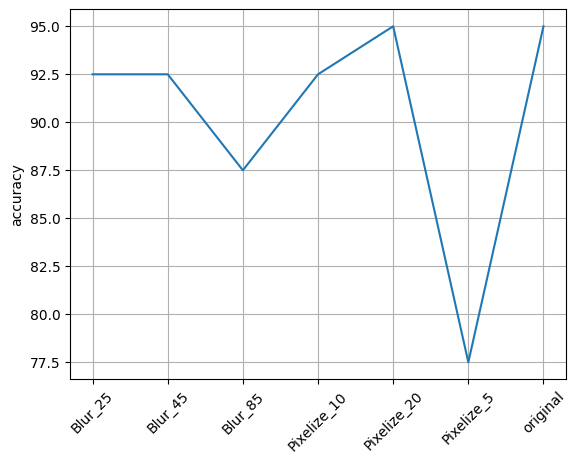

In [ ]:
import matplotlib.pyplot as plt


lists = sorted(filenameToAccuracy.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.ylabel("accuracy")
plt.plot(x, y)
plt.xticks(rotation=45)
plt.grid(True)

plt.xticks(rotation=45)
plt.show()

In [ ]:
filenameToEpoch

{'Blur_25': 13,
 'Blur_45': 15,
 'Blur_85': 15,
 'Pixelize_20': 10,
 'Pixelize_10': 15,
 'Pixelize_5': 12,
 'original': 12}